# Задание 3. Python
## 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.stats import bootstrap
import requests
from urllib.parse import urlencode

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [10]:
def get_data_yandex(public_key,separator):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    
    ## получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 

    ## загружаем файл в df 
    download_response = requests.get(download_url) 
    return pd.read_csv(download_url, separator)

## На вход функция получает ссылку на яндекс диск и разделитель

In [11]:
group_add = get_data_yandex('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ',',')
groups = get_data_yandex('https://disk.yandex.ru/d/UhyYx41rTt3clQ',';')
checks = get_data_yandex('https://disk.yandex.ru/d/pH1q-VqcxXjsVA',';')
active_studs = get_data_yandex('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',';')

In [12]:
def metrics(groups,checks,group_add,active_studs):
    all_groups = pd.concat([groups, group_add], ignore_index=True)
    all_groups = all_groups.rename(columns = {'id':'student_id'})
    active = active_studs.merge(all_groups)
    tested = active.merge(checks,on = 'student_id',how='left').fillna(0)
    
    bought = tested.query('rev > 0') \
    .groupby('grp',as_index = False) \
    .agg({'rev':'count'}) \
    .rename(columns = {'rev':'users_bought'})
    
    alltested = tested.groupby('grp',as_index = False) \
    .agg({'rev':'count'}) \
    .rename(columns = {'rev':'alltested'})
    
    CR = bought.users_bought/alltested.alltested * 100
    
    AverageCheck = tested.query('rev > 0') \
    .groupby('grp') \
    .agg({'rev':'mean'}) \
    .rename(columns = {'rev':'AverageCheck'})
    
    
    df_metrics = bought.merge(alltested, on = 'grp')
    df_metrics['not_bought'] = alltested.alltested - bought.users_bought
    df_metrics = df_metrics.merge(AverageCheck,on = 'grp')
    df_metrics['CR'] = CR
    return df_metrics
## Функция с основными метриками.

In [13]:
metrics(groups,checks,group_add,active_studs)

,grp,users_bought,alltested,not_bought,AverageCheck,CR
0,A,78,1538,1460,933.589744,5.071521
1,B,314,6803,6489,1257.878992,4.615611


In [14]:
def build_graph():
        all_groups = pd.concat([groups, group_add], ignore_index=True)
        all_groups = all_groups.rename(columns = {'id':'student_id'})
        active = active_studs.merge(all_groups)
        tested = active.merge(checks,on = 'student_id',how='left').fillna(0)
        
        plt.figure(figsize = (13 ,7))
        sns.boxplot(data = tested.query('rev != 0'), x='grp',y='rev')   
        plt.xlabel('Test Group')
        plt.ylabel('Revenue')

## Функция с графиком общей выручки двух групп

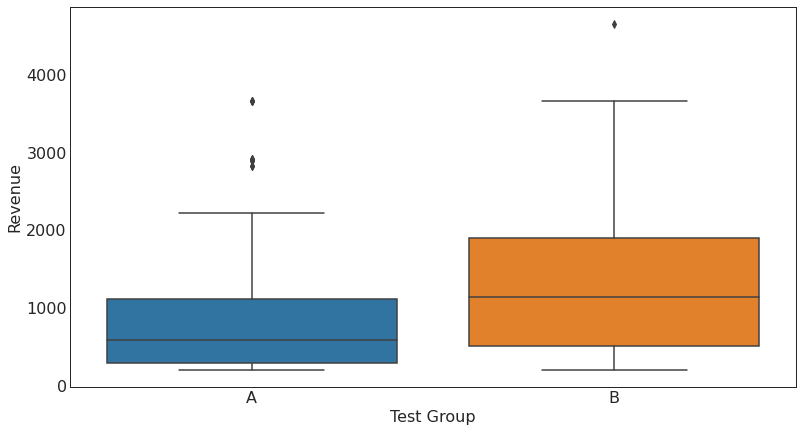

In [15]:
build_graph()